# Spectral Reconstruction: CAVE

In [1]:
import json
import pickle
from pathlib import Path

import optuna
import numpy as np
import pandas as pd
import spectral as spy
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('bgr', ['b', 'g', 'r'])

C:\Projects\suspectral\suspectral-notebook\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
optimize_hyperparameters = True

## Metrics

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2, axis=1))

def mrae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (y_true + 1), axis=1)

In [23]:
rmse_scorer = make_scorer(lambda y_true, y_pred: np.mean(rmse(y_true, y_pred)), greater_is_better=False)
mrae_scorer = make_scorer(lambda y_true, y_pred: np.mean(mrae(y_true, y_pred)), greater_is_better=False)

## Dataset

In [3]:
height, width = 512, 508
wavelengths = np.arange(400, 700 + 1, 10)

In [4]:
with open('resources/CAVE.json', 'r') as file:
    json_data = json.load(file)
    images_test = [Path(f'datasets/CAVE/{it}.hdr') for it in json_data['test']]
    images_train = [Path(f'datasets/CAVE/{it}.hdr') for it in json_data['train']]

In [5]:
def load(path: Path):
    envi = spy.io.envi.open(path)
    y = envi.load()
    y = y.reshape(-1, y.shape[-1])

    X = np.load(path.with_suffix('.npy'))
    X = X.reshape(-1, X.shape[-1])
    return X, y

In [6]:
def load_dataset(images: list[Path]):
    Xs, ys = [], []

    for path in images:
        X, y = load(path)
        Xs.append(X)
        ys.append(y)

    return np.vstack(Xs), np.vstack(ys)

In [7]:
X_train, y_train = load_dataset(images_train)

In [8]:
kf = KFold(n_splits=5, shuffle=False)

## Linear Regression

In [11]:
model_lr = LinearRegression(fit_intercept=False)
model_lr.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [12]:
with open('models/CAVE_LR.pkl', 'wb') as file:
    pickle.dump(model_lr, file, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
-np.mean(cross_val_score(model_lr, X_train, y_train, cv=kf, scoring=rmse_scorer))

np.float64(0.01933456477619609)

In [14]:
-np.mean(cross_val_score(model_lr, X_train, y_train, cv=kf, scoring=mrae_scorer))

np.float64(0.01113603030551739)

In [15]:
lr_mean_rmse_costs = []
lr_mean_mrae_costs = []

for path in tqdm(images_test):
    X_test, y_test = load(path)
    y_pred = model_lr.predict(X_test)

    lr_mean_rmse_costs.append(np.mean(rmse(y_test, y_pred)))
    lr_mean_mrae_costs.append(np.mean(mrae(y_test, y_pred)))

    del X_test, y_test, y_pred

pd.DataFrame({
    'Mean RMSE': lr_mean_rmse_costs,
    'Mean MRAE': lr_mean_mrae_costs,
}, index=images_test).describe()

100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


,Mean RMSE,Mean MRAE
count,2.000000,2.000000
mean,0.015467,0.008631
std,0.001015,0.001245
min,0.014749,0.007751
25%,0.015108,0.008191
50%,0.015467,0.008631
75%,0.015826,0.009071
max,0.016185,0.009512


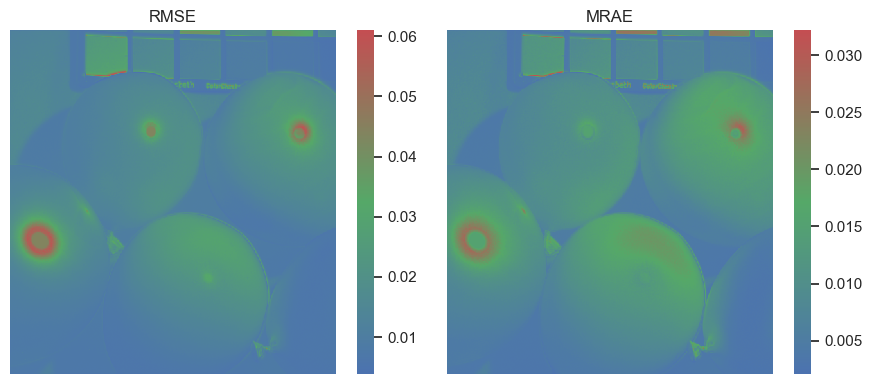

In [16]:
_, axes = plt.subplots(ncols=2, figsize=(9, 4))

X_test, y_test = load(images_test[0])
y_pred = model_lr.predict(X_test)

rmse_lr = rmse(y_test, y_pred)
rmse_lr = rmse_lr.reshape(height, width)

sns.heatmap(rmse_lr, cmap=cmap, ax=axes[0])
axes[0].set_title('RMSE')
axes[0].set_xticks([])
axes[0].set_yticks([])

mrae_lr = mrae(y_test, y_pred)
mrae_lr = mrae_lr.reshape(height, width)

sns.heatmap(mrae_lr, cmap=cmap, ax=axes[1])
axes[1].set_title('MRAE')
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

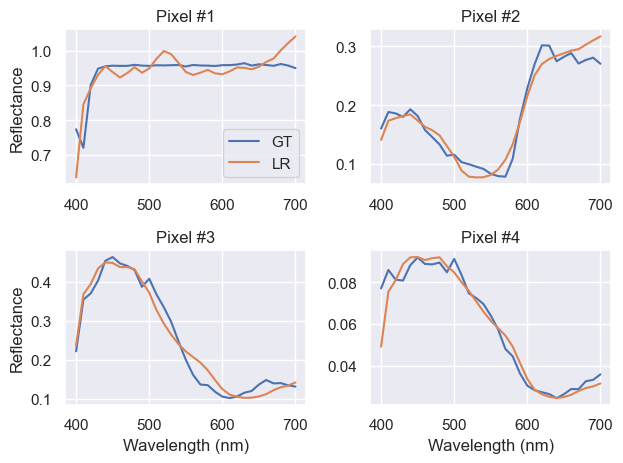

In [17]:
_, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].set_title('Pixel #1')
axes[0, 0].plot(wavelengths, y_test[149 * width + 222], label='GT')
axes[0, 0].plot(wavelengths, y_pred[149 * width + 222], label='LR')
axes[0, 0].set_ylabel('Reflectance')
axes[0, 0].legend()

axes[0, 1].set_title('Pixel #2')
axes[0, 1].plot(wavelengths, y_test[302 * width + 109], label='GT')
axes[0, 1].plot(wavelengths, y_pred[302 * width + 109], label='LR')

axes[1, 0].set_title('Pixel #3')
axes[1, 0].plot(wavelengths, y_test[333 * width + 271], label='GT')
axes[1, 0].plot(wavelengths, y_pred[333 * width + 271], label='LR')
axes[1, 0].set_xlabel('Wavelength (nm)')
axes[1, 0].set_ylabel('Reflectance')

axes[1, 1].set_title('Pixel #4')
axes[1, 1].plot(wavelengths, y_test[346 * width + 489], label='GT')
axes[1, 1].plot(wavelengths, y_pred[346 * width + 489], label='LR')
axes[1, 1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.savefig('LR-0.svg', bbox_inches='tight')

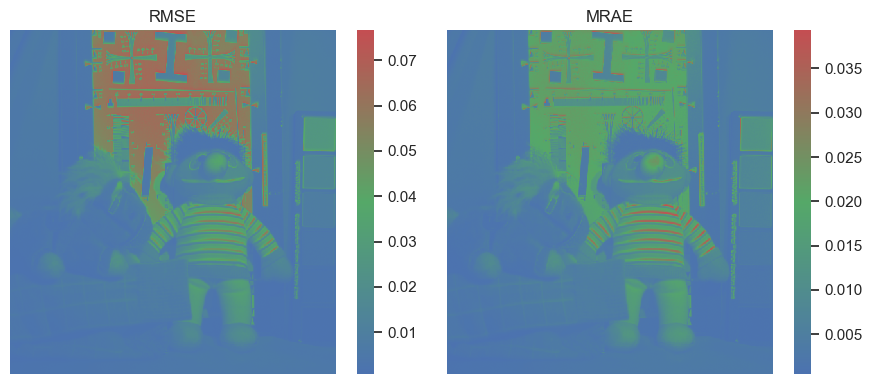

In [18]:
_, axes = plt.subplots(ncols=2, figsize=(9, 4))

X_test, y_test = load(images_test[1])
y_pred = model_lr.predict(X_test)

rmse_lr = rmse(y_test, y_pred)
rmse_lr = rmse_lr.reshape(height, width)

sns.heatmap(rmse_lr, cmap=cmap, ax=axes[0])
axes[0].set_title('RMSE')
axes[0].set_xticks([])
axes[0].set_yticks([])

mrae_lr = mrae(y_test, y_pred)
mrae_lr = mrae_lr.reshape(height, width)

sns.heatmap(mrae_lr, cmap=cmap, ax=axes[1])
axes[1].set_title('MRAE')
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

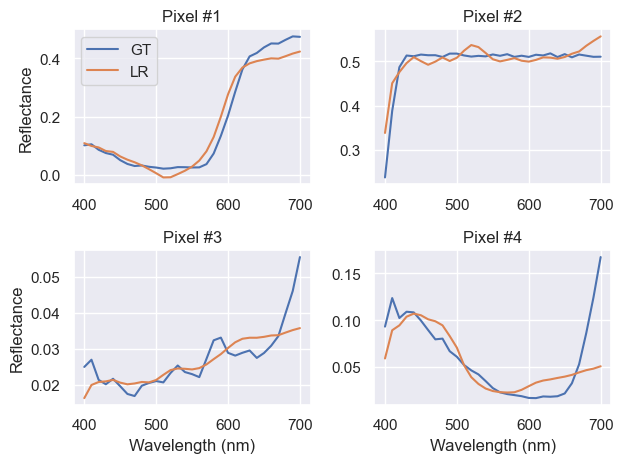

In [19]:
_, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].set_title('Pixel #1')
axes[0, 0].plot(wavelengths, y_test[197 * width + 324], label='GT')
axes[0, 0].plot(wavelengths, y_pred[197 * width + 324], label='LR')
axes[0, 0].set_ylabel('Reflectance')
axes[0, 0].legend()

axes[0, 1].set_title('Pixel #2')
axes[0, 1].plot(wavelengths, y_test[153 * width + 485], label='GT')
axes[0, 1].plot(wavelengths, y_pred[153 * width + 485], label='LR')

axes[1, 0].set_title('Pixel #3')
axes[1, 0].plot(wavelengths, y_test[288 * width + 164], label='GT')
axes[1, 0].plot(wavelengths, y_pred[288 * width + 164], label='LR')
axes[1, 0].set_xlabel('Wavelength (nm)')
axes[1, 0].set_ylabel('Reflectance')

axes[1, 1].set_title('Pixel #4')
axes[1, 1].plot(wavelengths, y_test[400 * width + 355], label='GT')
axes[1, 1].plot(wavelengths, y_pred[400 * width + 355], label='LR')
axes[1, 1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.savefig('LR-1.svg', bbox_inches='tight')

In [20]:
del X_test, y_test, y_pred

## Polynomial Regression

In [21]:
def pr_objective(trial):
    alpha = trial.suggest_float('alpha', 1e-6, 1e2, log=True)
    order = trial.suggest_int('order', 2, 6)

    X_train_poly = PolynomialFeatures(degree=order, include_bias=False) \
        .fit_transform(X_train)

    model = Ridge(alpha=alpha, fit_intercept=False)
    return -np.mean(cross_val_score(
        model, X_train_poly, y_train, cv=kf, scoring=mrae_scorer))

In [22]:
if optimize_hyperparameters:
    study = optuna.create_study(direction='minimize')
    study.optimize(pr_objective, n_trials=100)

[I 2025-05-15 20:13:43,927] A new study created in memory with name: no-name-81cff324-3e9a-46f5-a94b-2a07a9c2d7c7
[I 2025-05-15 20:15:13,167] Trial 0 finished with value: 0.009555799942661486 and parameters: {'alpha': 34.77111644900446, 'order': 4}. Best is trial 0 with value: 0.009555799942661486.
[I 2025-05-15 20:17:25,674] Trial 1 finished with value: 0.009318078203816471 and parameters: {'alpha': 13.867785161541157, 'order': 5}. Best is trial 1 with value: 0.009318078203816471.
[I 2025-05-15 20:18:54,967] Trial 2 finished with value: 0.008791655083870241 and parameters: {'alpha': 1.001543137280521, 'order': 4}. Best is trial 2 with value: 0.008791655083870241.
[I 2025-05-15 20:19:42,997] Trial 3 finished with value: 0.009912955796230269 and parameters: {'alpha': 2.6941332307439797e-05, 'order': 2}. Best is trial 2 with value: 0.008791655083870241.
[I 2025-05-15 20:22:59,005] Trial 4 finished with value: 0.008652092529824369 and parameters: {'alpha': 1.0447491562531905, 'order': 6}.

KeyboardInterrupt: 

In [23]:
model_pr = Pipeline([
    ('poly', PolynomialFeatures(degree=6, include_bias=False)),
    ('ridge', Ridge(alpha=0.0001647050258728194))
])
model_pr.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=6, include_bias=False)),
                ('ridge', Ridge(alpha=0.0001647050258728194))])

In [ ]:
with open('models/CAVE_PR.pkl', 'wb') as file:
    pickle.dump(model_pr, file, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
-np.mean(cross_val_score(model_pr, X_train, y_train, cv=kf, scoring=rmse_scorer))

np.float64(0.013566932894248106)

In [26]:
-np.mean(cross_val_score(model_pr, X_train, y_train, cv=kf, scoring=mrae_scorer))

np.float64(0.007681758458794222)

In [ ]:
pr_mean_rmse_costs = []
pr_mean_mrae_costs = []

for path in tqdm(images_test):
    X_test, y_test = load(path)
    y_pred = model_pr.predict(X_test)

    pr_mean_rmse_costs.append(np.mean(rmse(y_test, y_pred)))
    pr_mean_mrae_costs.append(np.mean(mrae(y_test, y_pred)))

    del X_test, y_test, y_pred

pd.DataFrame({
    'Mean RMSE': pr_mean_rmse_costs,
    'Mean MRAE': pr_mean_mrae_costs,
}, index=images_test).describe()

In [ ]:
_, axes = plt.subplots(ncols=2, figsize=(9, 4))

X_test, y_test = load(images_test[0])
y_pred = model_pr.predict(X_test)

rmse_pr = rmse(y_test, y_pred)
rmse_pr = rmse_pr.reshape(height, width)

sns.heatmap(rmse_pr, cmap=cmap, ax=axes[0])
axes[0].set_title('RMSE')
axes[0].set_xticks([])
axes[0].set_yticks([])

mrae_pr = mrae(y_test, y_pred)
mrae_pr = mrae_pr.reshape(height, width)

sns.heatmap(mrae_pr, cmap=cmap, ax=axes[1])
axes[1].set_title('MRAE')
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
_, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].set_title('Pixel #1')
axes[0, 0].plot(wavelengths, y_test[149 * width + 222], label='GT')
axes[0, 0].plot(wavelengths, y_pred[149 * width + 222], label='PR')
axes[0, 0].set_ylabel('Reflectance')
axes[0, 0].legend()

axes[0, 1].set_title('Pixel #2')
axes[0, 1].plot(wavelengths, y_test[302 * width + 109], label='GT')
axes[0, 1].plot(wavelengths, y_pred[302 * width + 109], label='PR')

axes[1, 0].set_title('Pixel #3')
axes[1, 0].plot(wavelengths, y_test[333 * width + 271], label='GT')
axes[1, 0].plot(wavelengths, y_pred[333 * width + 271], label='PR')
axes[1, 0].set_xlabel('Wavelength (nm)')
axes[1, 0].set_ylabel('Reflectance')

axes[1, 1].set_title('Pixel #4')
axes[1, 1].plot(wavelengths, y_test[346 * width + 489], label='GT')
axes[1, 1].plot(wavelengths, y_pred[346 * width + 489], label='PR')
axes[1, 1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.savefig('PR-0.svg', bbox_inches='tight')

In [ ]:
_, axes = plt.subplots(ncols=2, figsize=(9, 4))

X_test, y_test = load(images_test[1])
y_pred = model_pr.predict(X_test)

rmse_pr = rmse(y_test, y_pred)
rmse_pr = rmse_pr.reshape(height, width)

sns.heatmap(rmse_pr, cmap=cmap, ax=axes[0])
axes[0].set_title('RMSE')
axes[0].set_xticks([])
axes[0].set_yticks([])

mrae_pr = mrae(y_test, y_pred)
mrae_pr = mrae_pr.reshape(height, width)

sns.heatmap(mrae_pr, cmap=cmap, ax=axes[1])
axes[1].set_title('MRAE')
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
_, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].set_title('Pixel #1')
axes[0, 0].plot(wavelengths, y_test[197 * width + 324], label='GT')
axes[0, 0].plot(wavelengths, y_pred[197 * width + 324], label='PR')
axes[0, 0].set_ylabel('Reflectance')
axes[0, 0].legend()

axes[0, 1].set_title('Pixel #2')
axes[0, 1].plot(wavelengths, y_test[153 * width + 485], label='GT')
axes[0, 1].plot(wavelengths, y_pred[153 * width + 485], label='PR')

axes[1, 0].set_title('Pixel #3')
axes[1, 0].plot(wavelengths, y_test[288 * width + 164], label='GT')
axes[1, 0].plot(wavelengths, y_pred[288 * width + 164], label='PR')
axes[1, 0].set_xlabel('Wavelength (nm)')
axes[1, 0].set_ylabel('Reflectance')

axes[1, 1].set_title('Pixel #4')
axes[1, 1].plot(wavelengths, y_test[400 * width + 355], label='GT')
axes[1, 1].plot(wavelengths, y_pred[400 * width + 355], label='PR')
axes[1, 1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.savefig('PR-1.svg', bbox_inches='tight')

## Model: RELS

In [9]:
from regression import RELS

In [10]:
X_train_poly = PolynomialFeatures(degree=6, include_bias=False) \
    .fit_transform(X_train)

In [38]:
rels_models = []

for train_index, val_index in tqdm(kf.split(y_train)):
    model = RELS(n_features=83, n_bands=len(wavelengths), epsilon=1)
    model.add(X_train_poly[train_index], y_train[train_index])
    rels_models.append(model)

5it [07:51, 94.39s/it]


In [39]:
def rels_objective(trial):
    alphas = [
        trial.suggest_float(f'alpha[{i}]', 1e-6, 1e2, log=True)
        for i in range(len(wavelengths))
    ]

    scores = []
    for k, (train_index, val_index) in enumerate(kf.split(y_train)):
        model = rels_models[k].fit(alphas=alphas)
        y_pred = model.predict(X_train_poly[val_index])
        y_true = y_train[val_index]
        scores.append(np.mean(mrae(y_pred, y_true)))

    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(rels_objective, n_trials=1000)

[I 2025-05-15 23:46:47,577] A new study created in memory with name: no-name-69f9ef9c-1bf0-41c5-9aef-3d2a48e211e9


In [14]:
study.best_params

{'alpha[0]': 9.167940851994347e-05,
 'alpha[1]': 1.62308017250488e-05,
 'alpha[2]': 3.143669764668418e-05,
 'alpha[3]': 8.4837786407067e-06,
 'alpha[4]': 0.0002006697277782615,
 'alpha[5]': 0.9523717975669214,
 'alpha[6]': 7.224517297584274e-05,
 'alpha[7]': 6.592710540437391e-06,
 'alpha[8]': 0.002108766622579387,
 'alpha[9]': 6.624336445561342e-05,
 'alpha[10]': 7.417790397163852e-05,
 'alpha[11]': 0.0026594965964144516,
 'alpha[12]': 0.002181538984838119,
 'alpha[13]': 0.0003499529036507485,
 'alpha[14]': 0.00023282105643388691,
 'alpha[15]': 0.04132309257046656,
 'alpha[16]': 1.6526542578010536e-05,
 'alpha[17]': 0.0005819712548505592,
 'alpha[18]': 0.07828054570588462,
 'alpha[19]': 0.3857591606862261,
 'alpha[20]': 2.913099685744614e-06,
 'alpha[21]': 0.00032569002888711645,
 'alpha[22]': 0.02313055393152699,
 'alpha[23]': 0.6620896349170335,
 'alpha[24]': 0.0004152663407148254,
 'alpha[25]': 0.01142977612936923,
 'alpha[26]': 6.390928798191094e-05,
 'alpha[27]': 0.00566947554746

In [19]:
model_rels = RELS(n_features=83, n_bands=len(wavelengths), epsilon=1)
model_rels.add(X_train_poly, y_train)

In [20]:
model_rels.fit(alphas=[
 9.167940851994347e-05,
 1.62308017250488e-05,
 3.143669764668418e-05,
 8.4837786407067e-06,
 0.0002006697277782615,
 0.9523717975669214,
 7.224517297584274e-05,
 6.592710540437391e-06,
 0.002108766622579387,
 6.624336445561342e-05,
 7.417790397163852e-05,
 0.0026594965964144516,
 0.002181538984838119,
 0.0003499529036507485,
 0.00023282105643388691,
 0.04132309257046656,
 1.6526542578010536e-05,
 0.0005819712548505592,
 0.07828054570588462,
 0.3857591606862261,
 2.913099685744614e-06,
 0.00032569002888711645,
 0.02313055393152699,
 0.6620896349170335,
 0.0004152663407148254,
 0.01142977612936923,
 6.390928798191094e-05,
 0.005669475547460803,
 2.576524095522732e-05,
 0.0020733081840595895,
 2.8474972490522377
])

In [21]:
with open('models/CAVE_RELS.pkl', 'wb') as file:
    pickle.dump(model_rels, file, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
rmse_scores = []
mrae_scores = []
for train_index, val_index in kf.split(y_train):
    model = RELS(n_features=83, n_bands=len(wavelengths), epsilon=1)
    model.add(X_train_poly[train_index], y_train[train_index])
    model.fit(alphas=model_rels.alphas_)

    y_pred = model.predict(X_train_poly[val_index])
    y_true = y_train[val_index]
    rmse_scores.append(np.mean(rmse(y_pred, y_true)))
    mrae_scores.append(np.mean(mrae(y_true, y_pred)))

In [34]:
np.mean(rmse_scores)

np.float64(0.01469235174784889)

In [35]:
np.mean(mrae_scores)

np.float64(0.00811908591812107)

In [31]:
rels_mean_rmse_costs = []
rels_mean_mrae_costs = []

for path in tqdm(images_test):
    X_test, y_test = load(path)
    y_pred = model_rels.predict(PolynomialFeatures(degree=6, include_bias=False).fit_transform(X_test))

    rels_mean_rmse_costs.append(np.mean(rmse(y_test, y_pred)))
    rels_mean_mrae_costs.append(np.mean(mrae(y_test, y_pred)))

    del X_test, y_test, y_pred

pd.DataFrame({
    'Mean RMSE': rels_mean_rmse_costs,
    'Mean MRAE': rels_mean_mrae_costs,
}, index=images_test).describe()

100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


,Mean RMSE,Mean MRAE
count,2.000000,2.000000
mean,0.014584,0.008248
std,0.002966,0.002552
min,0.012486,0.006444
25%,0.013535,0.007346
50%,0.014584,0.008248
75%,0.015633,0.009150
max,0.016682,0.010053


## Comparison

In [ ]:
X_test, y_test = load_dataset(images_test)

In [ ]:
y_pred_lr = model_lr.predict(X_test)
y_pred_pr = model_pr.predict(X_test)

In [ ]:
pca_test = PCA(n_components=4).fit(y_test)
pca_pred_lr = PCA(n_components=4).fit(y_pred_lr)
pca_pred_pr = PCA(n_components=4).fit(y_pred_pr)

In [ ]:
pca_df = pd.DataFrame(np.vstack((
    pca_test.explained_variance_ratio_,
    pca_pred_lr.explained_variance_ratio_,
    pca_pred_pr.explained_variance_ratio_,
)), index=['GT', 'LR', 'PR'])

pca_df

In [ ]:
print(pca_df.map(lambda x: f'{x:.2e}').to_csv(sep='\t'))

In [ ]:
_, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].set_title(f'Component #1')
axes[0, 0].plot(wavelengths, pca_test.components_[0], label='GT')
axes[0, 0].plot(wavelengths, pca_pred_lr.components_[0], label='LR')
axes[0, 0].plot(wavelengths, pca_pred_pr.components_[0], label='PR')
axes[0, 0].set_ylabel('Reflectance')
axes[0, 0].legend()

axes[0, 1].set_title(f'Component #2')
axes[0, 1].plot(wavelengths, pca_test.components_[1], label='GT')
axes[0, 1].plot(wavelengths, pca_pred_lr.components_[1], label='LR')
axes[0, 1].plot(wavelengths, pca_pred_pr.components_[1], label='PR')

axes[1, 0].set_title(f'Component #3')
axes[1, 0].plot(wavelengths, pca_test.components_[2], label='GT')
axes[1, 0].plot(wavelengths, pca_pred_lr.components_[2], label='LR')
axes[1, 0].plot(wavelengths, pca_pred_pr.components_[2], label='PR')
axes[1, 0].set_xlabel('Wavelength (nm)')
axes[1, 0].set_ylabel('Reflectance')

axes[1, 1].set_title(f'Component #4')
axes[1, 1].plot(wavelengths, pca_test.components_[3], label='GT')
axes[1, 1].plot(wavelengths, pca_pred_lr.components_[3], label='LR')
axes[1, 1].plot(wavelengths, pca_pred_pr.components_[3], label='PR')
axes[1, 1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.savefig('PCA.svg', bbox_inches='tight')

In [ ]:
rmse_costs = [rmse_lr, rmse_pr]
rmse_vmin = min(cost.min() for cost in rmse_costs)
rmse_vmax = max(cost.max() for cost in rmse_costs)

In [ ]:
mrae_costs = [mrae_lr, mrae_pr]
mrae_vmin = min(cost.min() for cost in mrae_costs)
mrae_vmax = max(cost.max() for cost in mrae_costs)

In [ ]:
colors = ['#494ca0', '#72bf75', '#9a4545']

In [ ]:
cmap2 = LinearSegmentedColormap.from_list('bgr', colors)

In [ ]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))

sns.heatmap(rmse_lr, cmap=cmap2, ax=axes[0, 0], vmin=rmse_vmin, vmax=rmse_vmax)
axes[0, 0].set_title('LR')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

sns.heatmap(mrae_lr, cmap=cmap2, ax=axes[1, 0], vmin=mrae_vmin, vmax=mrae_vmax)
axes[1, 0].set_ylabel('MRAE')
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])

sns.heatmap(rmse_pr, cmap=cmap2, ax=axes[0, 1], vmin=rmse_vmin, vmax=rmse_vmax)
axes[0, 1].set_title('PR')
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

sns.heatmap(mrae_pr, cmap=cmap2, ax=axes[1, 1], vmin=mrae_vmin, vmax=mrae_vmax)
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])

# sns.heatmap(rmse_pr, cmap=cmap2, ax=axes[0, 2], vmin=rmse_vmin, vmax=rmse_vmax)
# axes[0, 2].set_title('RELS')
# axes[0, 2].set_xticks([])
# axes[0, 2].set_yticks([])
#
# sns.heatmap(mrae_pr, cmap=cmap2, ax=axes[1, 2], vmin=mrae_vmin, vmax=mrae_vmax)
# axes[1, 2].set_xticks([])
# axes[1, 2].set_yticks([])

plt.tight_layout()
plt.savefig('heatmap.png', bbox_inches='tight', transparent=True)